# Finetune ResNet50


With 224x224 silence-removed melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'resnet50_224silence'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [14]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 20

C:\Users\profi\AppData\Local\Temp\ipykernel_21672\29953048.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/20


Validating: 100%|██████████| 75/75 [00:10<00:00,  7.37it/s, Loss=1.0786648988723755, Elapsed=20.9412s, ETA=0.0000s] 


Epoch 1 completed in 76.3568s
Train Loss: 1.4051063501765961 - Train Accuracy: 42.312475972954026
Validation Loss: 1.28404807249705 - Validation Accuracy: 45.27226677923174

Epoch 2/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.33it/s, Loss=0.941089391708374, Elapsed=19.7650s, ETA=0.0000s]  


Epoch 2 completed in 71.2865s
Train Loss: 1.2542547762738487 - Train Accuracy: 46.912100585694574
Validation Loss: 1.2473227826754252 - Validation Accuracy: 47.47783875052765

Epoch 3/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.33it/s, Loss=0.8533140420913696, Elapsed=19.7850s, ETA=0.0000s] 


Epoch 3 completed in 71.3099s
Train Loss: 1.2074575000415648 - Train Accuracy: 48.64657063386174
Validation Loss: 1.2295050565401713 - Validation Accuracy: 47.03461376108062

Epoch 4/20


Validating: 100%|██████████| 75/75 [00:08<00:00,  8.38it/s, Loss=0.7863947749137878, Elapsed=19.6773s, ETA=0.0000s] 


Epoch 4 completed in 70.8800s
Train Loss: 1.1808606946054911 - Train Accuracy: 49.66870943669298
Validation Loss: 1.1879248722394307 - Validation Accuracy: 47.9421696918531

Epoch 5/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.15it/s, Loss=0.7249889969825745, Elapsed=20.1626s, ETA=0.0000s] 


Epoch 5 completed in 71.5365s
Train Loss: 1.1611419513046397 - Train Accuracy: 50.075755862599216
Validation Loss: 1.1808953603108725 - Validation Accuracy: 49.46179822710004

Epoch 6/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.32it/s, Loss=0.9166874289512634, Elapsed=19.7494s, ETA=0.0000s] 


Epoch 6 completed in 70.9512s
Train Loss: 1.1501193132703704 - Train Accuracy: 50.638836751769524
Validation Loss: 1.1749032402038575 - Validation Accuracy: 50.01055297593921

Epoch 7/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.28it/s, Loss=0.8581591248512268, Elapsed=19.7437s, ETA=0.0000s] 


Epoch 7 completed in 70.9571s
Train Loss: 1.1378223405063497 - Train Accuracy: 50.95316704733045
Validation Loss: 1.2100387223561604 - Validation Accuracy: 49.081891093288306

Epoch 8/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.31it/s, Loss=0.6386504173278809, Elapsed=19.8074s, ETA=0.0000s] 


Epoch 8 completed in 71.1265s
Train Loss: 1.1279293882709018 - Train Accuracy: 51.61574817394451
Validation Loss: 1.2005021675427754 - Validation Accuracy: 47.93161671591389

Epoch 9/20


Validating: 100%|██████████| 75/75 [00:08<00:00,  8.37it/s, Loss=0.7342530488967896, Elapsed=19.6278s, ETA=0.0000s] 


Epoch 9 completed in 70.9762s
Train Loss: 1.1153678056821659 - Train Accuracy: 51.83057823206168
Validation Loss: 1.1585135300954184 - Validation Accuracy: 48.607007176023636

Epoch 10/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.16it/s, Loss=0.7526394724845886, Elapsed=19.8681s, ETA=0.0000s] 


Epoch 10 completed in 70.9668s
Train Loss: 1.105437642404799 - Train Accuracy: 52.26023834829606
Validation Loss: 1.1417598565419516 - Validation Accuracy: 50.23216547066273

Epoch 11/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.24it/s, Loss=0.6701357364654541, Elapsed=19.7996s, ETA=0.0000s] 


Epoch 11 completed in 71.0642s
Train Loss: 1.0988152109818652 - Train Accuracy: 52.44567060898668
Validation Loss: 1.2488278365135193 - Validation Accuracy: 46.886872097931615

Epoch 12/20


Validating: 100%|██████████| 75/75 [00:08<00:00,  8.36it/s, Loss=0.9923496246337891, Elapsed=19.4920s, ETA=0.0000s] 


Epoch 12 completed in 70.6197s
Train Loss: 1.0903734094490205 - Train Accuracy: 52.83236471359761
Validation Loss: 1.1374562271436055 - Validation Accuracy: 53.36639932460954

Epoch 13/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.23it/s, Loss=0.8644764423370361, Elapsed=20.3144s, ETA=0.0000s] 


Epoch 13 completed in 71.4037s
Train Loss: 1.0831143382312245 - Train Accuracy: 53.067547093010106
Validation Loss: 1.160548600355784 - Validation Accuracy: 50.369354157872515

Epoch 14/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.12it/s, Loss=0.6438888311386108, Elapsed=19.9513s, ETA=0.0000s] 


Epoch 14 completed in 71.3051s
Train Loss: 1.0812365221494884 - Train Accuracy: 53.099206259469476
Validation Loss: 1.1289821283022563 - Validation Accuracy: 50.92866188265091

Epoch 15/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.30it/s, Loss=0.8106932640075684, Elapsed=19.7892s, ETA=0.0000s] 


Epoch 15 completed in 71.6882s
Train Loss: 1.0647779449906651 - Train Accuracy: 53.35926369824292
Validation Loss: 1.1351026900609333 - Validation Accuracy: 51.87842971718024

Epoch 16/20


Validating: 100%|██████████| 75/75 [00:08<00:00,  8.44it/s, Loss=0.7412872314453125, Elapsed=19.4624s, ETA=0.0000s] 


Epoch 16 completed in 70.5910s
Train Loss: 1.0651647338288368 - Train Accuracy: 53.44971845955542
Validation Loss: 1.1282756837209065 - Validation Accuracy: 53.59856479527226

Epoch 17/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.32it/s, Loss=0.8141264319419861, Elapsed=19.5202s, ETA=0.0000s] 


Epoch 17 completed in 70.8243s
Train Loss: 1.0563820548829315 - Train Accuracy: 54.08064041971009
Validation Loss: 1.1271724573771158 - Validation Accuracy: 52.90206838328408

Epoch 18/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.29it/s, Loss=0.7891291975975037, Elapsed=19.6175s, ETA=0.0000s] 


Epoch 18 completed in 71.0893s
Train Loss: 1.0501366495397049 - Train Accuracy: 54.29547047782728
Validation Loss: 1.1226998051007588 - Validation Accuracy: 53.72520050654285

Epoch 19/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.20it/s, Loss=0.8304798603057861, Elapsed=19.8240s, ETA=0.0000s] 


Epoch 19 completed in 71.0778s
Train Loss: 1.0409623772078167 - Train Accuracy: 54.61658488048665
Validation Loss: 1.1279467630386353 - Validation Accuracy: 54.15787252005065

Epoch 20/20


Validating: 100%|██████████| 75/75 [00:09<00:00,  8.22it/s, Loss=1.153835415840149, Elapsed=19.6753s, ETA=0.0000s]  

Epoch 20 completed in 70.8272s
Train Loss: 1.0404720211649217 - Train Accuracy: 54.60980077338821
Validation Loss: 1.1465401196479796 - Validation Accuracy: 53.13423385394681



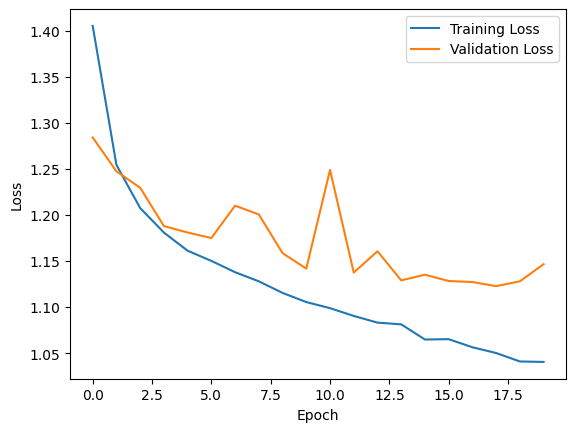

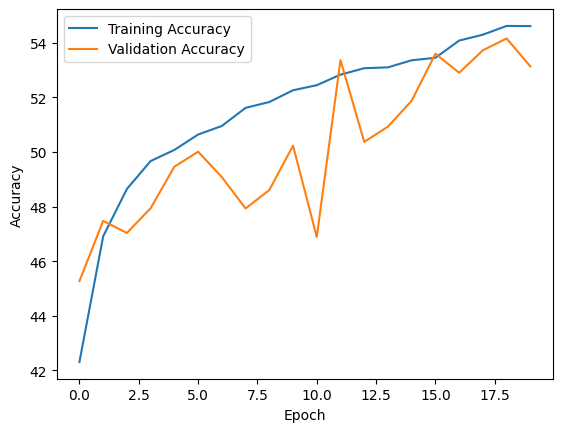

In [15]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evalaute best model on test set


In [17]:
def get_predictions(model, testloader, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    print("Evaluating best model on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

Define the function to print out the evaluation metrics


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_21672\3256607076.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:21<00:00,  3.54it/s]

Test Accuracy: 0.5378
Test Precision: 0.5595
Test Recall: 0.5378
Test F1-score: 0.5282

              precision    recall  f1-score   support

       Anger       0.45      0.67      0.54       916
       Bored       0.64      0.86      0.73      1098
     Disgust       0.31      0.60      0.41       291
        Fear       0.32      0.56      0.41       308
       Happy       0.53      0.38      0.44      1914
     Neutral       0.63      0.35      0.45      2226
    Question       0.60      0.73      0.66      1139
         Sad       0.61      0.49      0.54       857
    Surprise       0.51      0.61      0.55       728

    accuracy                           0.54      9477
   macro avg       0.51      0.58      0.53      9477
weighted avg       0.56      0.54      0.53      9477



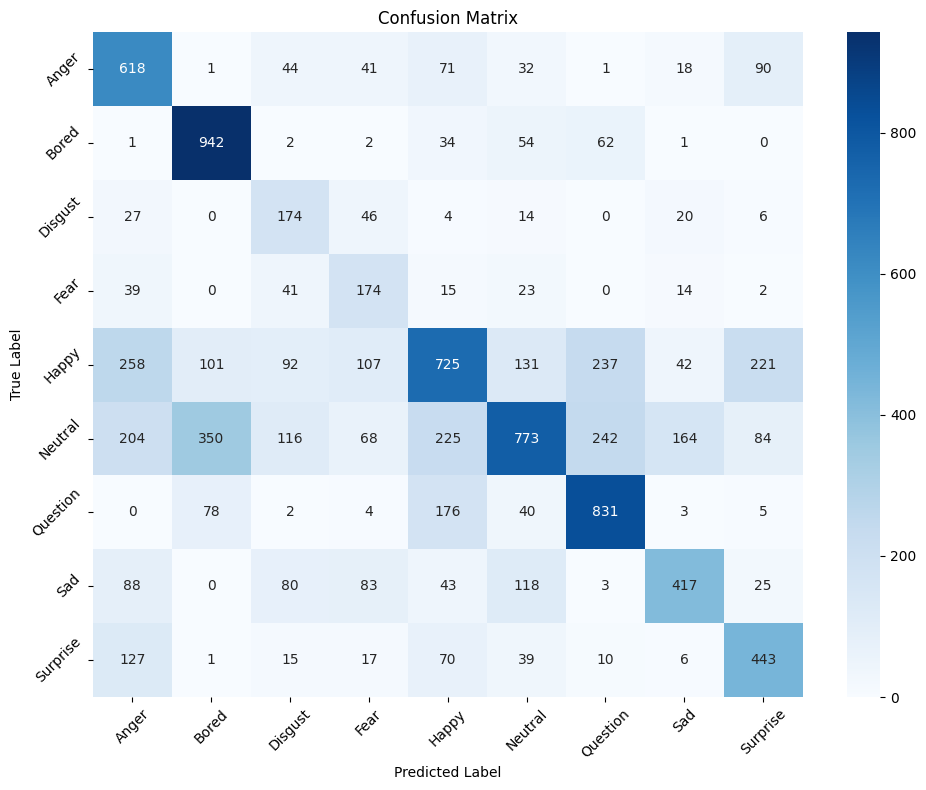

In [19]:
# Load and get predictions from the bets model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
all_preds, all_labels = get_predictions(
    model=model,
    testloader=testloader,
    device=device,
    model_path=best_model_path
)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, labelmap)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)